# Segment 3 Lab 2

Understanding a Large Language Model

This is also available at this colab:

https://colab.research.google.com/drive/10LJw_o08sBaaeJxCrLWo2ypbdFRMBtjV#scrollTo=Z-Scxg24RXeI

In [1]:
from dotenv import load_dotenv

In [2]:
load_dotenv(override=True)

True

In [3]:
from openai import OpenAI
openai = OpenAI()

In [5]:
import networkx as nx
import matplotlib.pyplot as plt
from typing import List, Dict, Tuple
import json
import math

class TokenPredictor:
    def __init__(self, model_name: str):
        self.client = OpenAI()
        self.messages = []
        self.predictions = []
        self.model_name = model_name
        
    def predict_tokens(self, prompt: str, max_tokens: int = 100) -> List[Dict]:
        """
        Generate text token by token and track prediction probabilities.
        Returns list of predictions with top token and alternatives.
        """
        response = self.client.chat.completions.create(
            model=self.model_name,
            messages=[{"role": "user", "content": prompt}],
            max_tokens=max_tokens,
            temperature=0,  # Use temperature 0 for deterministic output
            logprobs=True,
            seed=42,
            top_logprobs=3,  # Get top 3 token predictions
            stream=True  # Stream the response
        )
        
        predictions = []
        for chunk in response:
            if chunk.choices[0].delta.content:
                token = chunk.choices[0].delta.content
                logprobs = chunk.choices[0].logprobs.content[0].top_logprobs
                logprob_dict = {item.token: item.logprob for item in logprobs}
                
                # Get top predicted token and probability
                top_token = token
                top_prob = logprob_dict[token]
                
                # Get alternative predictions
                alternatives = []
                for alt_token, alt_prob in logprob_dict.items():
                    if alt_token != token:
                        alternatives.append((alt_token, math.exp(alt_prob)))
                alternatives.sort(key=lambda x: x[1], reverse=True)
                
                prediction = {
                    'token': top_token,
                    'probability': math.exp(top_prob),
                    'alternatives': alternatives[:2]  # Keep top 2 alternatives
                }
                predictions.append(prediction)
                
        return predictions

def create_token_graph(model_name:str, predictions: List[Dict]) -> nx.DiGraph:
    """
    Create a directed graph showing token predictions and alternatives.
    """
    G = nx.DiGraph()

    G.add_node("START", 
               token=model_name,
               prob="START",
               color='lightgreen',
               size=4000)
    
    # First, create all main token nodes in sequence
    for i, pred in enumerate(predictions):
        token_id = f"t{i}"
        G.add_node(token_id, 
                  token=pred['token'],
                  prob=f"{pred['probability']*100:.1f}%",
                  color='lightblue',
                  size=6000)
        
        if i == 0:
            G.add_edge("START", token_id)
        else:
            G.add_edge(f"t{i-1}", token_id)
    
    # Then add alternative nodes with a different y-position
    last_id = None
    for i, pred in enumerate(predictions):
        parent_token = "START" if i == 0 else f"t{i-1}"
        
        # Add alternative token nodes slightly below main sequence
        for j, (alt_token, alt_prob) in enumerate(pred['alternatives']):
            alt_id = f"t{i}_alt{j}"
            G.add_node(alt_id,
                      token=alt_token,
                      prob=f"{alt_prob*100:.1f}%",
                      color='lightgray',
                      size=6000)
            
            # Add edge from main token to its alternatives only
            G.add_edge(parent_token, alt_id)
            last_id = parent_token
            

    G.add_node("END", 
               token="END",
               prob="100%",
               color='red',
               size=6000)
    G.add_edge(last_id, "END")
    
    return G

def visualize_predictions(G: nx.DiGraph, figsize=(14, 150)):
    """
    Visualize the token prediction graph with vertical layout and alternating alternatives.
    """
    plt.figure(figsize=figsize)
    
    # Create custom positioning for nodes
    pos = {}
    spacing_y = 10  # Vertical spacing between main tokens
    spacing_x = 5  # Horizontal spacing for alternatives
    
    # Position main token nodes in a vertical line
    main_nodes = [n for n in G.nodes() if '_alt' not in n]
    for i, node in enumerate(main_nodes):
        pos[node] = (0, -i * spacing_y)  # Center main tokens vertically
    
    # Position alternative nodes to left and right of main tokens
    for node in G.nodes():
        if '_alt' in node:
            main_token = node.split('_')[0]
            alt_num = int(node.split('_alt')[1])
            if main_token in pos:
                # Place first alternative to left, second to right
                x_offset = -spacing_x if alt_num == 0 else spacing_x
                pos[node] = (x_offset, pos[main_token][1] + 0.05)
    
    # Draw nodes
    node_colors = [G.nodes[node]['color'] for node in G.nodes()]
    node_sizes = [G.nodes[node]['size'] for node in G.nodes()]
    nx.draw_networkx_nodes(G, pos, node_color=node_colors, node_size=node_sizes)

    # Draw all edges as straight lines
    nx.draw_networkx_edges(G, pos, edge_color='gray', arrows=True, arrowsize=20, alpha=0.7)
    
    # Add labels with token and probability
    labels = {node: f"{G.nodes[node]['token']}\n{G.nodes[node]['prob']}"
              for node in G.nodes()}
    nx.draw_networkx_labels(G, pos, labels, font_size=14)
    
    plt.title("Token prediction.")
    plt.axis('off')
    
    # Adjust plot limits to ensure all nodes are visible
    margin = 8
    x_values = [x for x, y in pos.values()]
    y_values = [y for x, y in pos.values()]
    plt.xlim(min(x_values) - margin, max(x_values) + margin)
    plt.ylim(min(y_values) - margin, max(y_values) + margin)
    
    # plt.tight_layout()
    plt.show()

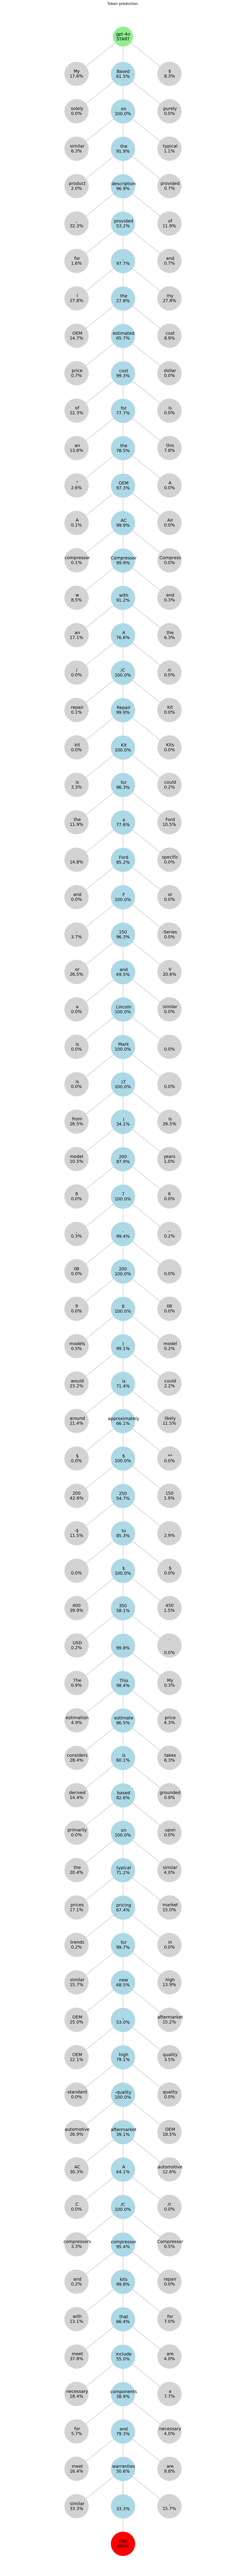

In [8]:
model_name = "gpt-4o"

predictor = TokenPredictor(model_name)

# Generate predictions
# prompt = "How would you describe the color blue to someone who has never been able to see, in no more than 3 sentences."
prompt = "Estimate exactly how much this product costs from this description; reply with your dollar estimate with a very short explanation:\nOEM AC Compressor w/A/C Repair Kit For Ford F150 F-150 V8 & Lincoln Mark LT 2007 2008 - BuyAutoParts NEW\nAs one of the world's largest automotive parts suppliers, our parts are trusted every day by mechanics and vehicle owners worldwide. This A/C Compressor and Components Kit is manufactured and tested to the strictest OE standards for unparalleled performance. Built for trouble-free ownership and 100% visually inspected and quality tested, this A/C Compressor and Components Kit is backed by our 100% satisfaction guarantee. Guaranteed Exact Fit for easy installation 100% BRAND NEW, premium ISO/TS 16949 quality - tested to meet or exceed OEM specifications Engineered for superior durability, backed by industry-leading unlimited-mileage warranty Included in this K"
predictions = predictor.predict_tokens(prompt)

# Create and visualize graph
G = create_token_graph(model_name, predictions)
visualize_predictions(G)